In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
autoregressive_models = []

In [5]:
def load_mnist_data(num_considered = []):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  if num_considered == []:
    train_data = np.concatenate((x_train, x_test), axis=0)
  else:
    train_data = None
    for num in num_considered:
      data_temp = x_train[y_train == num][:2000]
      train_data = np.concatenate((train_data, data_temp), axis=0) if train_data is not None else data_temp
  train_data = train_data.astype(int)
  train_data = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
  train_data = train_data.reshape(train_data.shape[0], -1).astype(np.float32)
  train_data = np.round(train_data)
  return train_data


## NADE Without parameter sharing

In [ ]:
train_data = load_mnist_data([7, 0])
train_data.shape

In [7]:
def model(input_size = 1):
  inputs = tf.keras.layers.Input(shape=(input_size,))
  x = tf.keras.layers.Dense(input_size//2, activation='leaky_relu')(inputs)
  ouput = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=ouput)
  return model

In [8]:
epochs = 100
batch_size = 1024

In [9]:
for i in range(784):
  print(f"Model_pixel_{i}")
  if i == 0:
    continue
  model_i = model(i)
  inputs = tf.cast(train_data[:,:i], tf.float32)
  target = tf.cast(train_data[:,i], tf.float32)
  h = model_i(inputs, training=False)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, weight_decay=1e-4)

  @tf.function
  def binary_crossentropy(target, h):
    return -tf.reduce_mean(target * tf.math.log(h + 1e-4) + (1 - target) * tf.math.log(1 - h + 1e-4))

  @tf.function
  def train_step(inputs, target):
    trainable_variables = model_i.trainable_variables
    with tf.GradientTape() as tape:
      h = model_i(inputs, training=True)
      loss = binary_crossentropy(target, h)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

  log_batch = 5

  for epoch in range(epochs):
        for start in range(0, train_data.shape[0], batch_size):
            end = start + batch_size
            loss = train_step(inputs[start:end], target[start:end])
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")
  print(f"Model_pixel_{i} trained")
  autoregressive_models.append(model_i)

Streaming output truncated to the last 5000 lines.
Epoch 100/100 - Loss: -0.0001
Model_pixel_734 trained
Model_pixel_735
Epoch 1/100 - Loss: -0.0001
Epoch 2/100 - Loss: -0.0001
Epoch 3/100 - Loss: -0.0001
Epoch 4/100 - Loss: -0.0001
Epoch 5/100 - Loss: -0.0001
Epoch 6/100 - Loss: -0.0001
Epoch 7/100 - Loss: -0.0001
Epoch 8/100 - Loss: -0.0001
Epoch 9/100 - Loss: -0.0001
Epoch 10/100 - Loss: -0.0001
Epoch 11/100 - Loss: -0.0001
Epoch 12/100 - Loss: -0.0001
Epoch 13/100 - Loss: -0.0001
Epoch 14/100 - Loss: -0.0001
Epoch 15/100 - Loss: -0.0001
Epoch 16/100 - Loss: -0.0001
Epoch 17/100 - Loss: -0.0001
Epoch 18/100 - Loss: -0.0001
Epoch 19/100 - Loss: -0.0001
Epoch 20/100 - Loss: -0.0001
Epoch 21/100 - Loss: -0.0001
Epoch 22/100 - Loss: -0.0001
Epoch 23/100 - Loss: -0.0001
Epoch 24/100 - Loss: -0.0001
Epoch 25/100 - Loss: -0.0001
Epoch 26/100 - Loss: -0.0001
Epoch 27/100 - Loss: -0.0001
Epoch 28/100 - Loss: -0.0001
Epoch 29/100 - Loss: -0.0001
Epoch 30/100 - Loss: -0.0001
Epoch 31/100 - Los

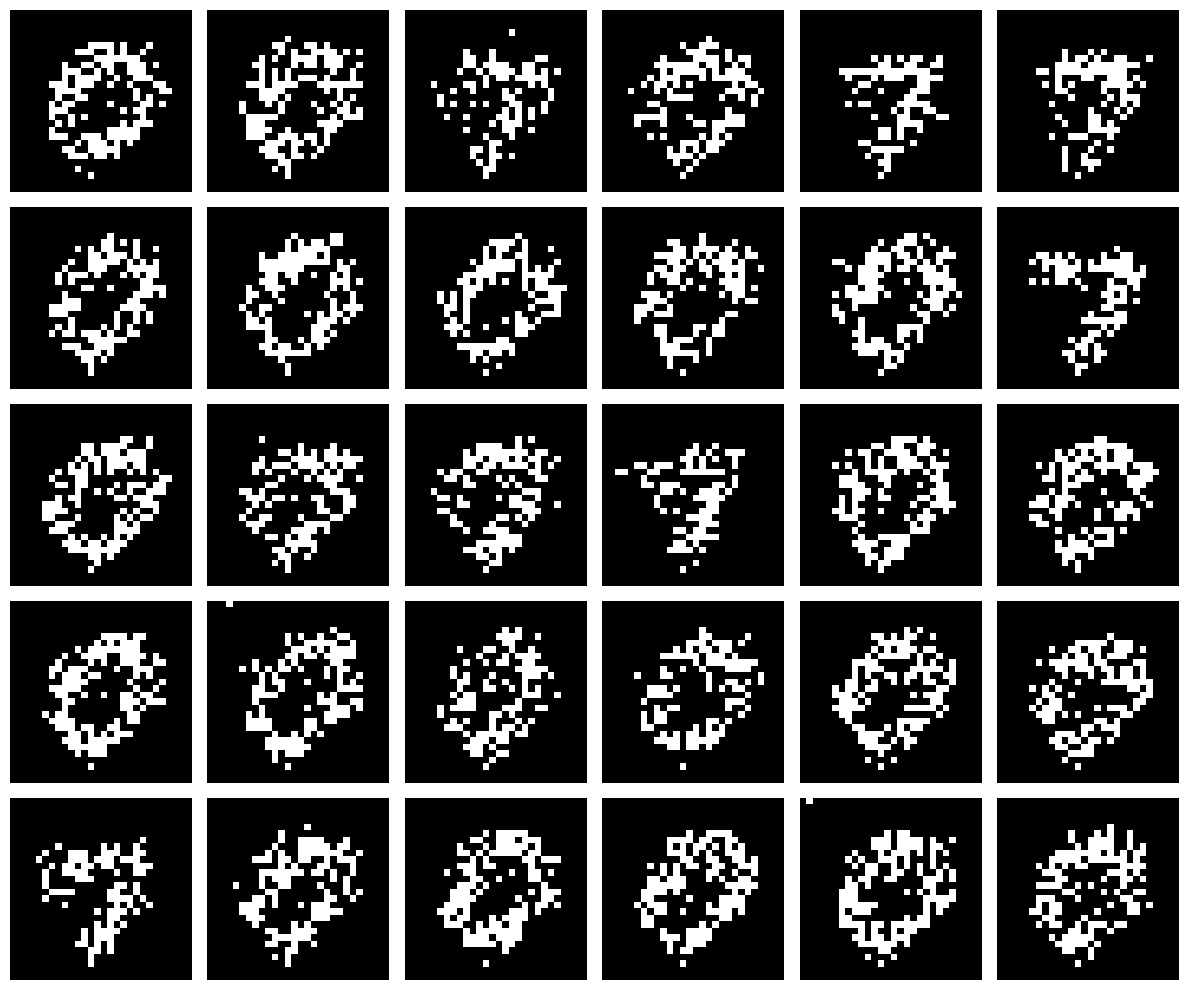

In [14]:
import matplotlib.pyplot as plt

num_pixels = 784
num_images = 30
generated_images = []

for img_idx in range(num_images):
    generated = np.zeros((num_pixels,), dtype=np.float32)
    generated[0] = 0.0

    for i in range(1, num_pixels):
        model_i = autoregressive_models[i - 1]
        x_input = tf.convert_to_tensor(generated[:i].reshape(1, -1), dtype=tf.float32)
        prob = model_i(x_input, training=False)[0, 0].numpy()
        generated[i] = np.random.binomial(1, prob)

    image = generated.reshape(28, 28)
    generated_images.append(image)


fig, axes = plt.subplots(5, 6, figsize=(12, 10))
axes = axes.flatten()

for i, image in enumerate(generated_images):
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()